In [1]:
# import necessary modules
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# importing and labeling the data

data_path = '/kaggle/input/dog-emotion/Dog Emotion/'

class_names=['angry', 'happy', 'relaxed', 'sad']
num_classes = len(class_names)

img_size = (192, 192, 3)


images = []
labels = []
labels_df = pd.read_csv(data_path + 'labels.csv')


for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(data_path + image[2] + '/' + image[1], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
    
    # converting labels into one-hot-encoding i.e., for sad label will be [0, 0, 0, 1]
    label = np.zeros(num_classes)
    label[class_names.index(image[2])] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

/tmp/ipykernel_170/330680658.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  images.append(np.asarray(cv2.resize(cv2.imread(data_path + image[2] + '/' + image[1], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
/tmp/ipykernel_170/330680658.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label[class_names.index(image[2])] = 1


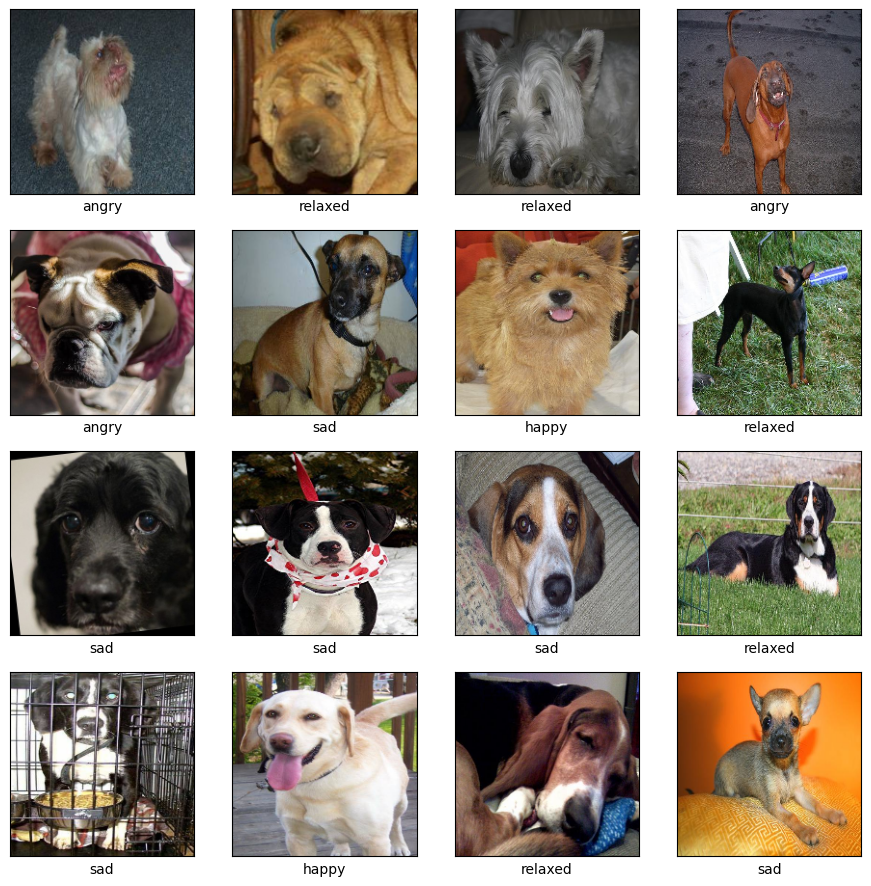

In [3]:
# display 16 pictures from the dataset

fig, axs = plt.subplots(4, 4, figsize=(11, 11))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))
        
        axs[x][y].imshow(images[i])
        
        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])
        
plt.show()

In [4]:
# dividing the data into train-val-test sets

X_train, X_trail, y_train, y_trail = train_test_split(images, labels, test_size=0.20, random_state=42, stratify=labels, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_trail, y_trail, test_size=0.7, random_state=42, stratify=y_trail, shuffle=True)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n\ntest images shape: {X_test.shape}\ntest labels shape: {y_test.shape}\n')

train images shape: (3200, 192, 192, 3)
train labels shape: (3200, 4)

validation images shape: (240, 192, 192, 3)
validation labels shape: (240, 4)

test images shape: (560, 192, 192, 3)
test labels shape: (560, 4)



In [5]:
# function for extracting features from the image

def feature_extractor(inputs):

# convolutional block 1
    x=tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(192,192,3))(inputs)
    x=tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x=tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# convolutional block 2
    x=tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x=tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x=tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# convolutional block 3
    x=tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same')(x)
    x=tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same')(x)
    x=tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# convolutional block 4
    x=tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same')(x)
    x=tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same')(x)
    x=tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    return x

In [6]:
# function for classification of emotion after feature extraction

def classifier(inputs):
    x=tf.keras.layers.Flatten()(inputs)
    x=tf.keras.layers.Dense(256, activation='relu')(x)
    x=tf.keras.layers.Dense(128, activation='relu')(x)
    x=tf.keras.layers.Dense(64, activation='relu')(x)
    x=tf.keras.layers.Dense(4, activation='softmax')(x)
    return x

In [7]:
# function for final model 

def final_model(inputs):
    feature_extract=feature_extractor(inputs)
    classification_output=classifier(feature_extract)
    return classification_output

In [8]:
# function to compile the model and finalize the architecture

def define_compile_model():
    inputs=tf.keras.layers.Input(shape=(192,192,3))

    # rescale the images so that values will be b/w 0 and 1   
    inputs=tf.keras.layers.Rescaling(scale=1. / 255)(inputs)
    
    classification_output=final_model(inputs)
    cnn_model=tf.keras.Model(inputs=inputs,outputs=classification_output)
    cnn_model.compile(optimizer="adamax",loss="categorical_crossentropy",metrics=["accuracy"])
    return cnn_model

In [9]:
# calling the function to initialize the model

cnn_model=define_compile_model()
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       32896     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 128)       65664     
                                                             

In [10]:
# defining the callbacks

callback = EarlyStopping(monitor = "loss", patience = 5, 
            restore_best_weights = True, mode='min')

In [11]:
# training the model for 25 epochs

history = cnn_model.fit(images, labels, epochs=25, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/25
125/125 [==============================] - 30s 142ms/step - loss: 2.3818 - accuracy: 0.2848 - val_loss: 1.3304 - val_accuracy: 0.3458
Epoch 2/25
125/125 [==============================] - 17s 134ms/step - loss: 1.2784 - accuracy: 0.3672 - val_loss: 1.2206 - val_accuracy: 0.4208
Epoch 3/25
125/125 [==============================] - 17s 134ms/step - loss: 1.2192 - accuracy: 0.4200 - val_loss: 1.1504 - val_accuracy: 0.4667
Epoch 4/25
125/125 [==============================] - 17s 134ms/step - loss: 1.1343 - accuracy: 0.4785 - val_loss: 1.0609 - val_accuracy: 0.5542
Epoch 5/25
125/125 [==============================] - 17s 134ms/step - loss: 1.0410 - accuracy: 0.5370 - val_loss: 0.8934 - val_accuracy: 0.6333
Epoch 6/25
125/125 [==============================] - 17s 134ms/step - loss: 0.8957 - accuracy: 0.6180 - val_loss: 0.7231 - val_accuracy: 0.7583
Epoch 7/25
125/125 [==============================] - 17s 134ms/step - loss: 0.7135 - accuracy: 0.7110 - val_loss: 0.5188 - val_ac

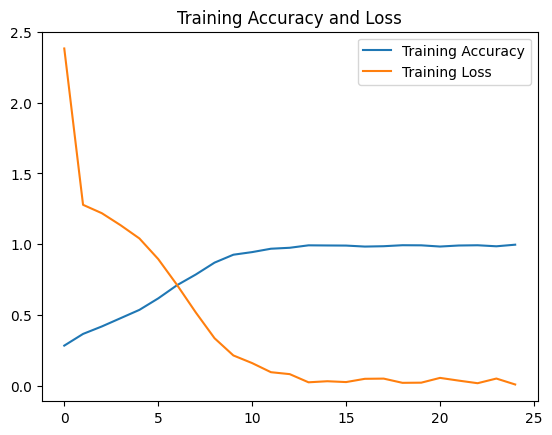

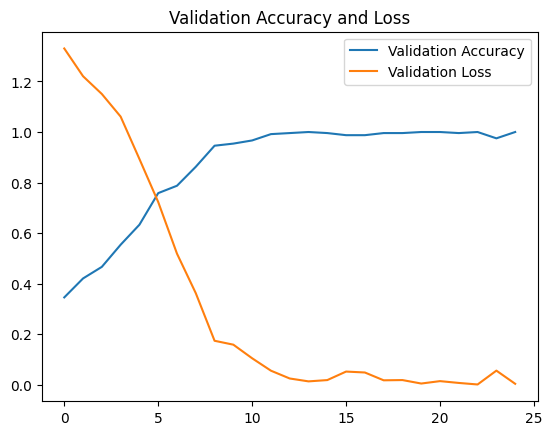

In [12]:
# plot the accuracy and loss curves

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

In [13]:
# evaluating the accuracy and loss in test set

cnn_model.evaluate(X_test,y_test)

18/18 [==============================] - 1s 39ms/step - loss: 0.0134 - accuracy: 0.9929


[0.013389614410698414, 0.9928571581840515]

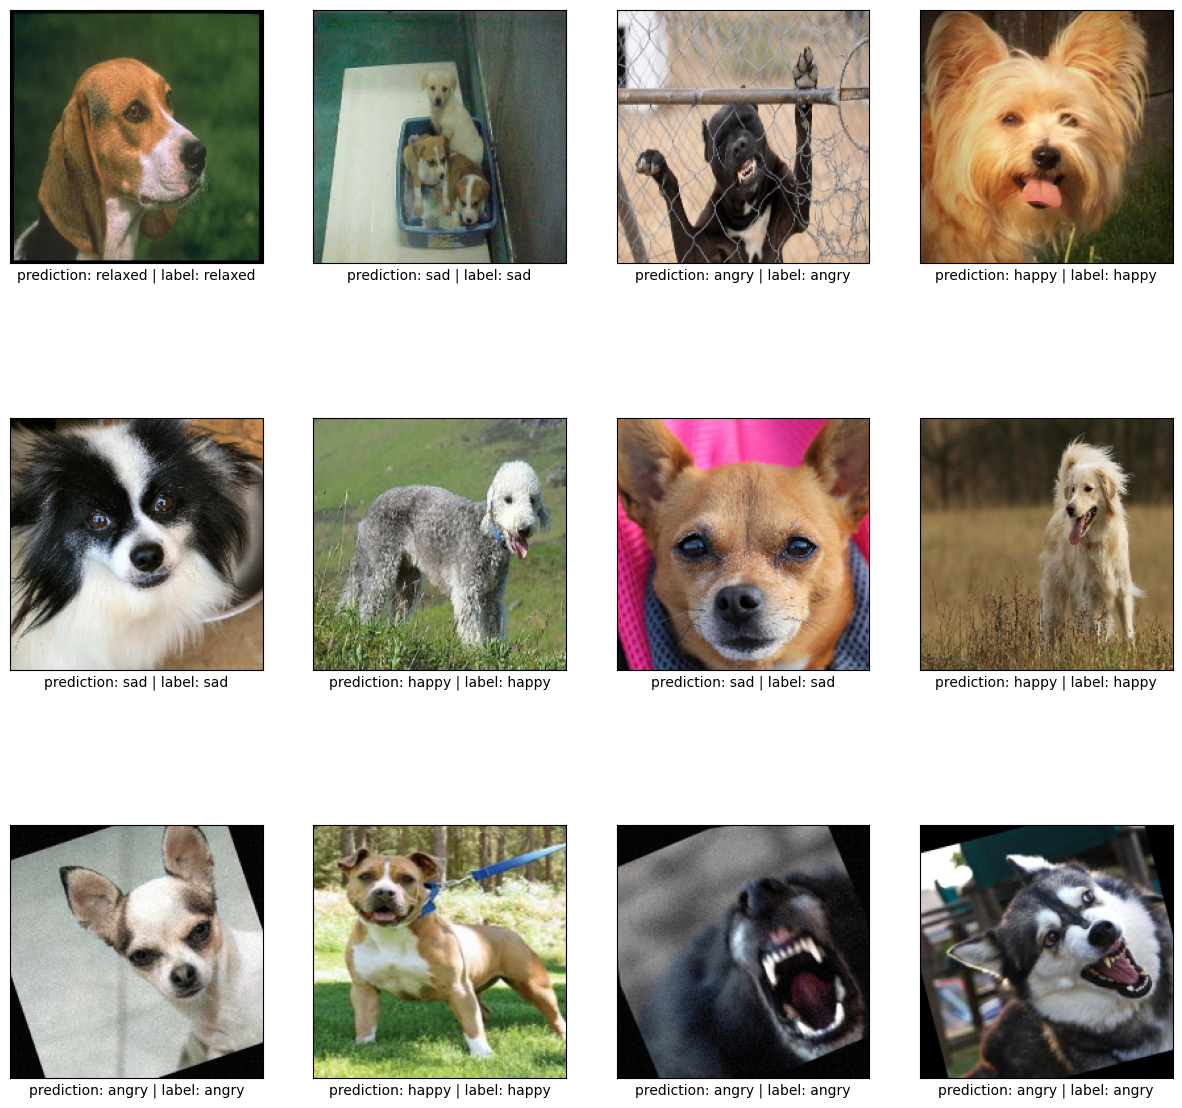

In [14]:
# display 12 images with prediction and actual labels in test set

fig, axs = plt.subplots(3, 4, figsize=(15, 15))

i = 0
for x in range(3):
    for y in range(4):
        prediction = cnn_model.predict(X_test[i][None, ...], verbose=0)[0]
        
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_test[i])]}')
        
        axs[x][y].imshow(X_test[i])
        
        i += 1
plt.show()

In [ ]:
# save the trained model

# cnn_model.save('emotion_detector.keras')